# Analysis of Cell-free and HIV - Figure 2

This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate figure 2.

## Author: 
 **Mark Kowarsky**
 
 - **Date Updated:** 2018-10-24


#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from collections import defaultdict
import os
from matplotlib import rcParams
import re
from Bio import Phylo


#from wordcloud import WordCloud
from matplotlib.colors import to_hex

from ete3 import NCBITaxa#,# TreeStyle, NodeStyle, faces

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr

from sklearn import decomposition, manifold

from adjustText import adjust_text

#%load_ext rpy2.ipython

In [2]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

## Load Design Matrix

In [3]:
design = pd.read_table("tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

# Panel A

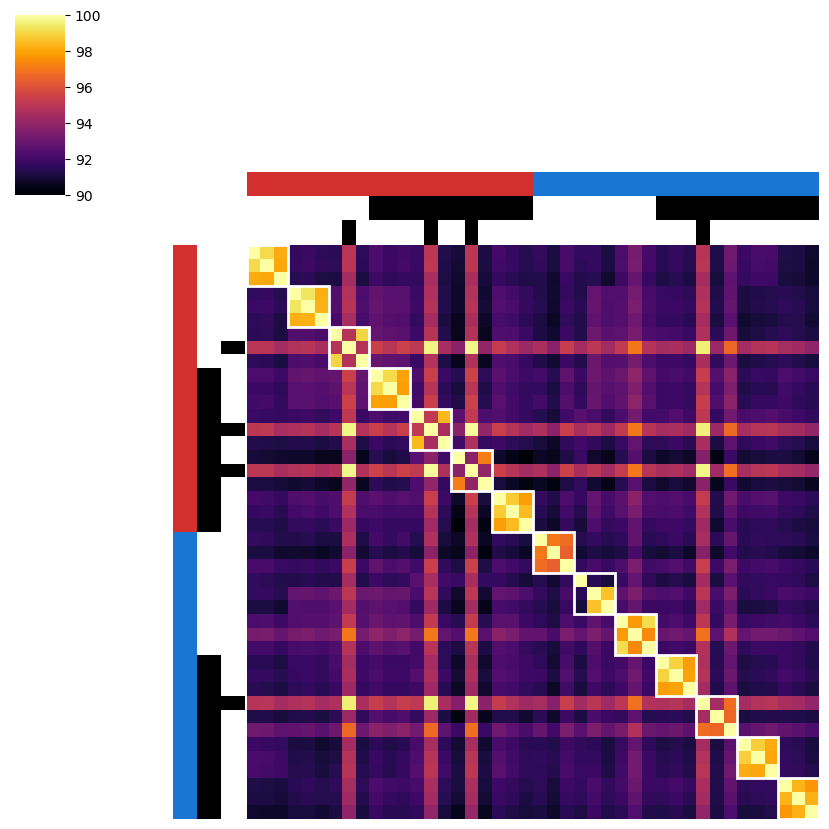

In [4]:
from matplotlib.patches import Rectangle

# Consensus sequences aligned with MUSCLE
PI = pd.read_table("tables/HIV/muscle-I20181030-172354-0885-82368258-p1m.csv", sep=",", header=None, index_col=0)
PI.columns = PI.index

colors = [21*[red] + 21*[blue],
          9*["white"] + 12*["black"] + 9*["white"] + 12*["black"],
          ["black" if i in [7, 13, 16, 33] else "white" for i in range(42)]]

# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

g = sns.clustermap(
    PI.loc[c, c], row_cluster=None, col_cluster=None,
    vmin=90, vmax=100, cmap="inferno",
    row_colors=colors, col_colors=colors, figsize=(10,10)
)

ax = g.ax_heatmap
labels = list(PI.loc[c, c].index)

# group contiguous replicates by prefix before the last underscore
def prefix(s):
    return s.rsplit('_', 1)[0] if '_' in s else s

groups = []
start = 0
for i in range(1, len(labels) + 1):
    if i == len(labels) or prefix(labels[i]) != prefix(labels[i-1]):
        groups.append((start, i - start))  # (start_index, group_length)
        start = i

# draw a white rim around each diagonal block
for start, size in groups:
    ax.add_patch(
        Rectangle((start - 0, start - 0), size, size,
                  fill=False, edgecolor="white", linewidth=2.0, zorder=3)
    )


ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(""); ax.set_ylabel("")
os.makedirs('figures/figure2/panel_A', exist_ok=True)
plt.savefig("figures/figure2/panel_A/s2_cluster_heatmap2.svg")
plt.show()


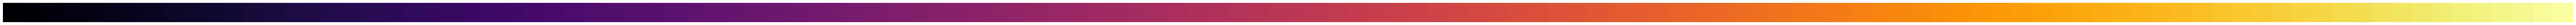

In [15]:
sns.palplot(sns.color_palette("inferno", n_colors=128))
plt.axis('off')
plt.savefig("figures/figure2/panel_A/inferno_palette.svg")

# Panel B - Treeplot
## Author: Yike Xie

In [5]:
# Manually define clusters to shade
cluster_defs = {
    "cluster_100008": ["100008_1", "100008_2", "100008_3"],
    "cluster_100137": ["100137_1", "100137_2", "100137_3", "CAP137"],
    "cluster_100177": ["100177_1", "CAP177", "100177_2", "100177_3"],
    "cluster_100200": ["100200_2", "CAP200", "100200_3"],
    "cluster_100206": ["100206_1", "CAP206", "100206_3"],
    "cluster_100248": ["100248_1", "100248_2", "CAP248", "100248_3"],
    "cluster_100217": ["100217_1", "100217_3", "CAP217", "100217_2"],
    "cluster_100257": ["100257_1", "100257_2", "100257_3", "CAP257"],
    "cluster_100261": ["100261_1", "CAP261", "100261_2", "100261_3"],
#     "cluster_100267": ["100267_2", "100267_3"],
    "cluster_mislabel": ["100200_1", "CAP239"],
    "cluster_100255": ["100255_1", "CAP255", "100255_3"],
    "cluster_100256": ["CAP256_superinfecting", "CAP256", "100256_1", "100256_3"],
    "cluster_100337": ["100337_1", "CAP337", "100337_2", "100337_3"],
    "cluster_100306": ["100306_1", "CAP306", "100306_2", "100306_3"],
    "cluster_CAP8": ["CAP8"]       # standalone
}

cluster_colors = {
    "cluster_100008": "lavenderblush",
    "cluster_100137": "lightyellow",
    "cluster_100177": "lightblue",
    "cluster_100200": "lightgreen",
    "cluster_100206": "mistyrose",
    "cluster_100248": "honeydew",
    "cluster_100217": "lightcyan",
    "cluster_100257": "azure",
    "cluster_100261": "thistle",
#     "cluster_100267": "cornsilk",
    "cluster_mislabel": "white",
    "cluster_100255": "wheat",
    "cluster_100256": "lightgray",
    "cluster_100337": "lightsteelblue",
    "cluster_100306": "lightpink",
    "cluster_CAP8": "lavenderblush"
}

In [6]:

tree = Phylo.read("phylo_tree_output/hiv_phylo_CAP256_super.treefile", "newick")

# Remove the two tips
for tip in ["CAP256"]:
    try:
        tree.prune(tip)
    except ValueError:
        print(f"Tip {tip} not found in tree.")

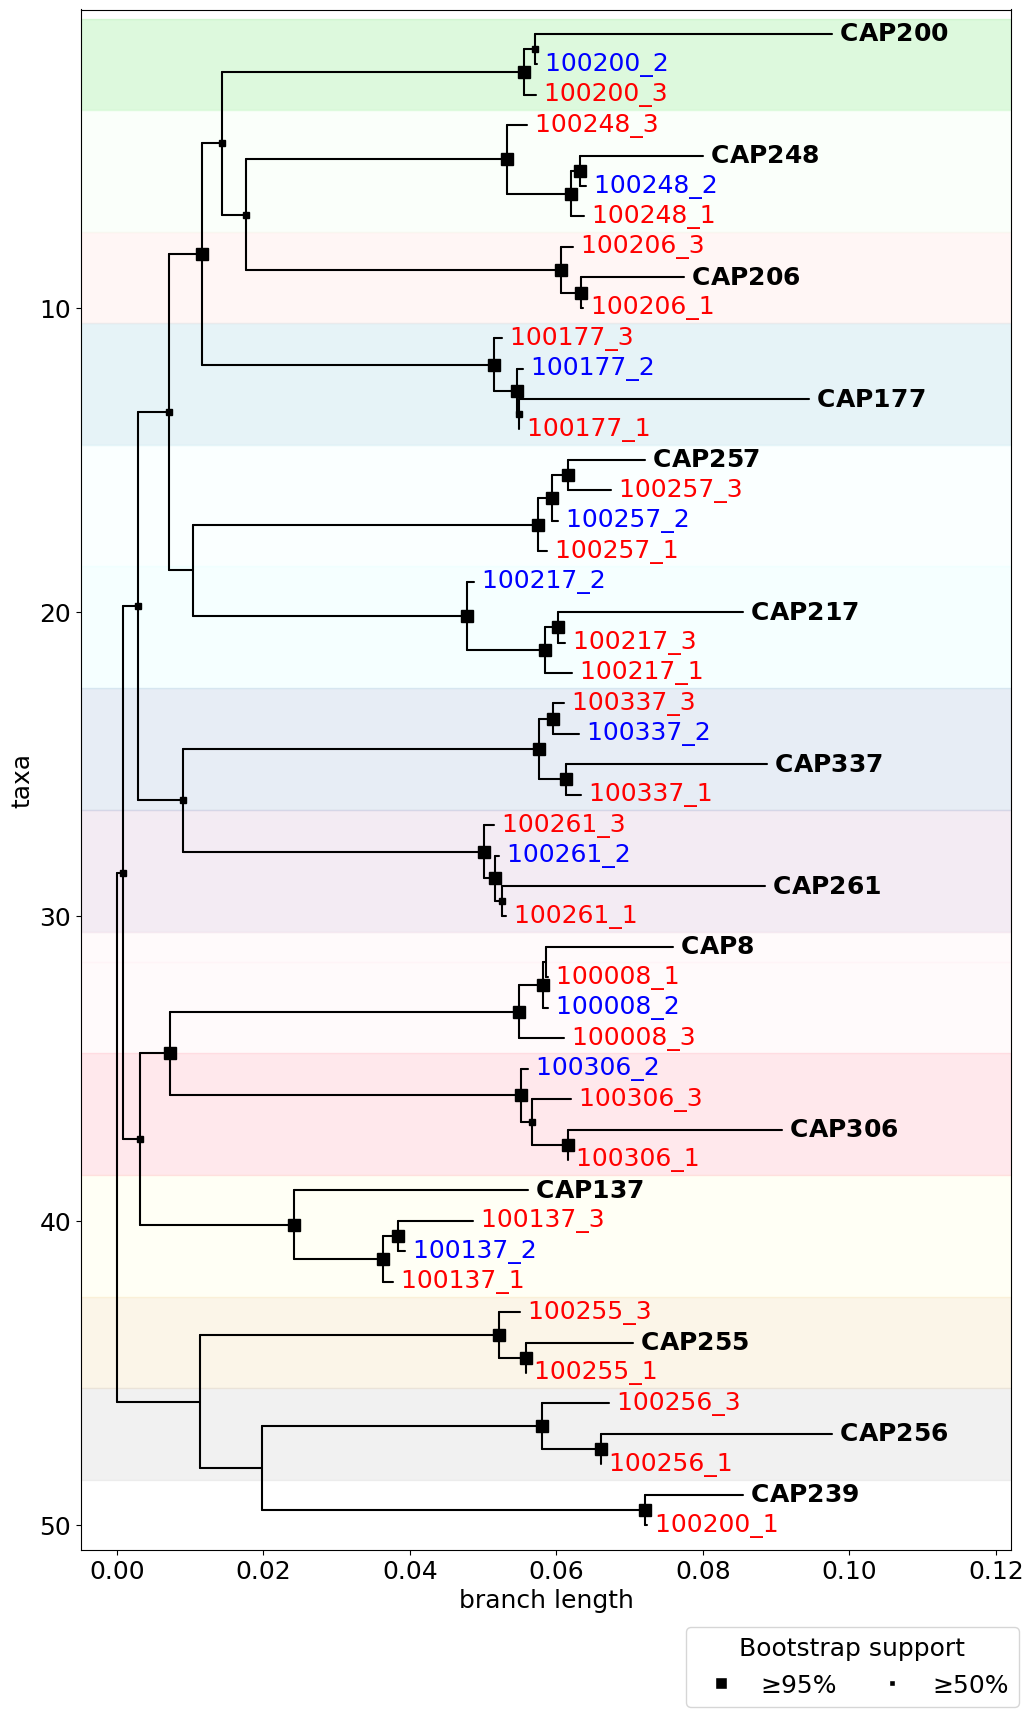

<Figure size 640x480 with 0 Axes>

In [7]:

rcParams['font.size']=18
rcParams['pdf.fonttype'] = 42
rcParams['text.usetex'] = False  # disable LaTeX entirely
rcParams['mathtext.default'] = 'regular'

# Load tree
tree.root_at_midpoint() 
meta = pd.read_csv("phylo_tree_output/sample_annotations_pruned.csv", index_col=0)

def label_func(clade):
    if clade.name:
        if clade.name.startswith("CAP") and "_" not in clade.name:
            return f"$\\bf{{{clade.name}}}$"  # bold only if safe
        elif clade.name.startswith("CAP") and "_" in clade.name:
            name = clade.name.split('_')[0]
            return f"$\\bf{{{name}}}$"
        else:
            return clade.name  # no LaTeX, no escaping
    return None
        

def calc_y(clade):
    if clade in clade_ypos2:
        return clade_ypos2[clade]
    if not clade.clades:
        return clade_ypos2.get(clade) 
    child_ys = [calc_y(child) for child in clade.clades if calc_y(child) is not None]
    if not child_ys:
        return None
    clade_ypos2[clade] = sum(child_ys) / len(child_ys)
    return clade_ypos2[clade]

label_colors = {name: row["color"] for name, row in meta.iterrows()}
    
# Draw tree and store label y-positions
fig, ax = plt.subplots(figsize=(12, 20))

clade_ypos = {}
ybase = tree.count_terminals()
for idx, clade in enumerate(tree.get_terminals()):
    clade_ypos[clade.name] = idx + 1  # reverse order

# backgrounds
for cluster, samples in cluster_defs.items():
    y_vals = [clade_ypos.get(s) for s in samples if s in clade_ypos]
    if y_vals:
        ymin = min(y_vals) - 0.5
        ymax = max(y_vals) + 0.5
        color = cluster_colors.get(cluster, "white")
        ax.axhspan(ymin, ymax, color=color, alpha=0.3)

clade_ypos2 = {}
y = 0
for clade in tree.get_terminals():
    clade_ypos2[clade] = y
    y += 1

calc_y(tree.root)
   
# Only valid y-pos clades
for clade in tree.get_nonterminals():
    if clade.confidence is None:
        continue
    y = clade_ypos2.get(clade)
    if y is None:
        continue     
    y += 1
    
    x = sum(a.branch_length or 0 for a in tree.get_path(clade))

    if clade.confidence >= 95:
        ax.plot(x, y, 's', color='black', markersize=8)
    elif clade.confidence >= 50:
        ax.plot(x, y, 's', color='black', markersize=4)

# Add legend 
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=8, 
           label='≥95%', markeredgewidth=1),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=4, 
           label='≥50%', markeredgewidth=1)
]
ax.legend(
    handles=legend_elements,
    title='Bootstrap support',
    bbox_to_anchor=[0.65, -0.05],
    loc='upper left',
    borderaxespad=0,
    ncols=2,
    handletextpad=0.6,
    columnspacing=1.2
)

# Draw tree again (on the top)
Phylo.draw(
    tree,
    axes=ax,
    label_func=label_func,
    show_confidence=False,
    label_colors=label_colors
)

plt.tight_layout()
plt.show()

os.makedirs('figures/figure2/panel_B/', exist_ok = True)
fig.savefig('figures/figure2/panel_B/sample_reference_tree_CAP256_final.svg', bbox_inches='tight', dpi=300)